In [1]:
from utilities import utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import Predictive, NUTS, MCMC
from pyro.infer.mcmc.util import summary
import os
plt.style.use('ggplot')

## Time Series as a Regression Problem

In [ ]:
co2_by_month = pd.read_csv(os.path.abspath('.') + '/data/monthly_mauna_loa_co2.csv')
co2_by_month["date_month"] = pd.to_datetime(co2_by_month["date_month"])
co2_by_month["CO2"] = co2_by_month["CO2"].astype(np.float32)
co2_by_month.set_index("date_month", drop=True, inplace=True)

num_forecast_steps = 12 * 10  # Forecast the final ten years, given previous data
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]
co2_by_month_testing_data = co2_by_month[-num_forecast_steps:]

In [ ]:
def plot_co2_data(fig_ax=None):
    if not fig_ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    else:
        fig, ax = fig_ax
    ax.plot(co2_by_month_training_data, label="training data")
    ax.plot(co2_by_month_testing_data, color="C4", label="testing data")
    ax.legend()
    ax.set(
        ylabel="Atmospheric CO₂ concentration (ppm)",
        xlabel="Year"
    )
    ax.text(0.99, .02,
            """Source: Scripps Institute for Oceanography CO₂ program
            http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record""",
            transform=ax.transAxes,
            horizontalalignment="right",
            alpha=0.5)
    fig.autofmt_xdate()
    return fig, ax


_ = plot_co2_data()

In [ ]:
trend_all = np.linspace(0., 1., len(co2_by_month)).reshape(-1, 1)
trend_all = trend_all.astype(np.float32)
trend = trend_all[:-num_forecast_steps, :]

seasonality_all = pd.get_dummies(
    co2_by_month.index.month).values.astype(np.float32)
seasonality = seasonality_all[:-num_forecast_steps, :]

fig, ax = plt.subplots(figsize=(10, 4))
X_subset = np.concatenate([trend, seasonality], axis=-1)[-50:]
im = ax.imshow(X_subset.T, cmap='cet_gray_r')

label_loc = np.arange(1, 50, 12)
ax.set_xticks(label_loc)
ax.set_yticks([])
ax.set_xticklabels(co2_by_month.index.year[-50:][label_loc])
fig.colorbar(im, ax=ax, orientation="horizontal", shrink=.6)

In [ ]:
seasonality = torch.tensor(seasonality, dtype=torch.float64).float()
trend = torch.tensor(trend, dtype=torch.float64).float()
co2 = torch.tensor(co2_by_month_training_data.values.flatten(), dtype=torch.float64).float()

In [ ]:
def ts_regression_model(trend, seasonality, obs=None):

    intercept = pyro.sample('intercept', dist.Normal(0., 100.))
    trend_coef = pyro.sample('trend_coef', dist.Normal(0., 10.).expand([trend.shape[-1]]))
    noise = pyro.sample('noise', dist.HalfCauchy(0.1, 5.))
    
    with pyro.plate('seasonality', seasonality.shape[-1]):
        season_coef = pyro.sample('season_coef', dist.Normal(0., 1.))

    y_hat = intercept + torch.matmul(trend_coef, trend.T) + torch.matmul(season_coef, seasonality.T)
    
    with pyro.plate('co2', len(trend)):
        #y_hat = intercept + torch.mul(trend_coef, trend) + torch.matmul(season_coef, seasonality.T)
        observed = pyro.sample('observed', dist.Normal(y_hat, noise), obs=obs)

In [ ]:
pyro.render_model(ts_regression_model, (trend, seasonality, co2), render_distributions=True)

In [ ]:
kernel = NUTS(ts_regression_model)
mcmc_regression = MCMC(kernel, 500, 100)
mcmc_regression.run(trend, seasonality, co2)

In [ ]:
mcmc_regression.summary()

In [ ]:
ts_samples = mcmc_regression.get_samples(1000)
post_samples = Predictive(ts_regression_model, ts_samples)(trend, seasonality, None)
az_ts_model = az.from_pyro(posterior=mcmc_regression, posterior_predictive=post_samples)

In [ ]:
az.plot_trace(az_ts_model)
plt.tight_layout()

In [ ]:
# prior samples
prior_samples = Predictive(ts_regression_model, {}, num_samples=100)(trend, seasonality)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    co2_by_month_training_data.index, prior_samples['observed'][0].T,
    alpha=0.5
    )
plt.show()

In [ ]:
trend_posterior = ts_samples['intercept'] + torch.mul(ts_samples['trend_coef'].mean(), trend)
season_posterior = torch.matmul(ts_samples['season_coef'], seasonality.T)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(
    co2_by_month_training_data.index, 
    trend_posterior.mean(axis=1)
    )

ax[1].plot(
    co2_by_month_training_data.index,
    season_posterior.mean(axis=0)
)

ax[0].set_title('Trend (Linear)')
ax[1].set_title('Seasonality (Month of the Year)')
plt.tight_layout()
plt.show()

In [ ]:
trend_all = torch.tensor(trend_all, dtype=torch.float64).float()
seasonality_all = torch.tensor(seasonality_all, dtype=torch.float64).float()

In [ ]:
post_samples = Predictive(ts_regression_model, ts_samples)(trend_all, seasonality_all, None)

In [ ]:
high = post_samples['observed'].mean(axis=0) + post_samples['observed'].std(axis=0)
low = post_samples['observed'].mean(axis=0) - post_samples['observed'].std(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(
    co2_by_month.index, post_samples['observed'].mean(axis=0),
    alpha=0.5
    )
ax.fill_between(x=co2_by_month.index, y1=high, y2=low, color='grey')
ax.set_title('Co2')
plot_co2_data((fig, ax))
plt.show()

### Design Matrices for Time Series

In [ ]:
n_changepoints = 8
n_tp = 500
t = np.linspace(0, 1, n_tp)
s = np.linspace(0, 1, n_changepoints + 2)[1:-1] ## doesn't subset first and last element
A = (t[:, None] > s) ## is val > changepoint val

k, m = 2.5, 40
delta = np.random.laplace(.1, size=n_changepoints) ## rate adj.
growth = (k + A @ delta) * t
offset = m + A @ (-s * delta)
trend = growth + offset

In [ ]:
_, ax = plt.subplots(4, 1, figsize=(10, 10))
ax[0].imshow(A.T, cmap="cet_gray_r", aspect='auto', interpolation='none');
ax[0].axis('off')
ax[0].set_title(r'$\mathbf{A}$')
ax[1].plot(t, growth, lw=2)
ax[1].set_title(r'$(k + \mathbf{A}\delta) t$')
ax[2].plot(t, offset, lw=2)
ax[2].set_title(r'$m + \mathbf{A} \gamma$')
ax[3].plot(t, trend, lw=2);
ax[3].set_title('Step linear function as trend');

lines = [np.where(t > s_)[0][0] for s_ in s]
for ax_ in ax[1:]:
    ax_.vlines(t[lines], *ax_.get_ylim(), linestyles='--');

plt.tight_layout()

### Basis Functions and Generalized Additive Model

**NOT FINISHED**

In [ ]:
def gen_fourier_basis(t, p=365.25, n=3):
    x = 2 * torch.pi * (torch.arange(n) + 1) * t[:, None] / p

    return torch.concatenate((torch.cos(x), torch.sin(x)), axis=1)

In [ ]:
n_tp = 500
p = 12
t_monthly = np.asarray([i % p for i in range(n_tp)])
monthly_X = gen_fourier_basis(t_monthly, p=p, n=3)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(monthly_X[:p*2, 0])
ax.plot(monthly_X[:p*2, 1:], alpha=.25)
plt.show()

In [ ]:
n_changepoints = 12
n_tp = seasonality.shape[0]
t = torch.linspace(0, 1, n_tp, dtype=torch.float64)
s = torch.linspace(0, max(t), n_changepoints + 2, dtype=torch.float64)[1:-1]
A = torch.tensor((t[:, None] > s), dtype=torch.float64)

In [ ]:
X_pred = gen_fourier_basis(
    torch.where(seasonality)[1],
    p=seasonality.shape[-1],
    n=6
)

n_pred = X_pred.shape[-1]

In [ ]:
mean_CO2 = torch.tensor(co2_by_month_training_data.reset_index()['CO2'].mean())

In [ ]:
beta = dist.Normal(0., 1.).expand([12]).sample().type(dtype=torch.float64)

k = dist.HalfNormal(10.).sample()
delta = dist.Laplace(0., dist.HalfNormal(10.).sample()).expand([12]).sample().type(dtype=torch.float64)

seasonality = torch.matmul(X_pred.type(dtype=torch.float64), beta)

growth_rate = k + torch.matmul(A, delta)

m = dist.Normal(mean_CO2, scale=5.).sample()
gamma = -s.type(dtype=torch.float64) * delta

offset = m + torch.matmul(A.type(dtype=torch.float64), gamma)
trend = torch.matmul(growth_rate, t.type(dtype=torch.float64)) + offset

y_hat = torch.add(seasonality, trend)

In [ ]:
X_pred.shape, seasonality.shape, growth_rate.shape, offset.shape, trend.shape

In [ ]:
def gam(fourier_x, mean_co2, A, s, t, obs=None):

    N, P = fourier_x.shape
    num_changepoints = 12

    k = pyro.sample('k', dist.HalfNormal(10.))
    m = pyro.sample('m', dist.Normal(float(mean_co2), scale=5.))
    tau = pyro.sample('tau', dist.HalfNormal(10.))

    with pyro.plate('season', P):
        beta = pyro.sample('beta', dist.Normal(0., 1.))
        delta = pyro.sample('delta', dist.Laplace(0., tau))

    seasonality = torch.matmul(fourier_x.type(dtype=torch.float64), beta.type(dtype=torch.float64))
    growth_rate = k + torch.matmul(A.type(dtype=torch.float64), delta.type(dtype=torch.float64))
    gamma = -s * delta.type(dtype=torch.float64).type(dtype=torch.float64)
    offset = m + torch.matmul(A, gamma)
    trend = torch.matmul(growth_rate, t.type(dtype=torch.float64)) + offset

    y_hat = torch.add(seasonality, trend)
    noise_sigma = pyro.sample('noise_sigma', dist.HalfNormal(5.))
    
    with pyro.plate('obs', N):
        observed = pyro.sample('output', dist.Normal(y_hat, noise_sigma), obs=obs)

In [ ]:
pyro.render_model(gam, (X_pred, mean_CO2, A, s, t, co2), render_distributions=True)

In [ ]:
kernel = NUTS(gam)
mcmc_gam = MCMC(kernel, 500, 300)
mcmc_gam.run(X_pred, mean_CO2, A, s, t, co2)

In [ ]:
mcmc_gam.summary()

In [ ]:
prior_samples = Predictive(gam, {}, num_samples=500)(X_pred, mean_CO2, A, s, t, None)

In [ ]:
gam_samples = mcmc_gam.get_samples(1000)
gam_predictive = Predictive(gam, gam_samples)(X_pred, mean_CO2, A, s, t, None)
az_gam = az.from_pyro(posterior=mcmc_gam, posterior_predictive=gam_predictive)

In [ ]:
az.plot_trace(az_gam)
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(co2_by_month_training_data.index, gam_predictive['output'].mean(axis=0))

## Autoregressive Models

**NOT FINISHED**

In [ ]:
def ar1_with_forloop(rho):
    n_t = 200
    sigma = pyro.sample('sigma', dist.HalfNormal(1.))
    x0 = pyro.sample('x0', dist.Normal(0., sigma))
    x = [x0]

    for i in range(1, n_t):
        x_i = pyro.sample('x_i', dist.Normal(x[i-1] * rho, sigma))
        x.append(x_i)
    
    return x

In [ ]:
nplot = 4
fig, axes = plt.subplots(nplot, 1, figsize=(10, 7))

for ax, rho in zip(axes, torch.linspace(-1.01, 1.01, nplot)):
    output = ar1_with_forloop(rho=rho)
    ax.plot(torch.arange(0, 200), output, label=r'$\rho=$%.2f' % rho)
    ax.legend(
        bbox_to_anchor=(1, 1), loc='upper left',
        borderaxespad=1., fontsize=10
        )
    plt.tight_layout()

### Latent AR Process and Smoothing

In [ ]:
num_steps = 100

x = np.linspace(0, 50, num_steps)
f = np.exp(1.0 + np.power(x, 0.5) - np.exp(x/15.0))
y = f + np.random.normal(scale=1.0, size=x.shape)

plt.figure(figsize=(8, 4))
plt.plot(x, y, 'ok', label='Observed')
plt.plot(x, f, 'r', label='f(x)')
plt.legend()
plt.xlabel('x');
plt.ylabel('y');

In [ ]:
def smoothing_grw(num_steps, obs=None):
    alpha = pyro.sample('alpha', dist.Beta(1., 1.))
    variance = pyro.sample('variance', dist.HalfNormal(10.))
    sigma_0 = torch.sqrt(variance * alpha)
    sigma_1 = torch.sqrt(variance * (1. - alpha))
    z = pyro.sample('z', dist.Normal(0., sigma_0).expand([num_steps]))

    with pyro.plate('obs', num_steps):

        output = pyro.sample(
            'output', dist.Normal(torch.cumsum(z, axis=-1), sigma_1[..., None]), obs=obs)


In [ ]:
pyro.render_model(smoothing_grw, (num_steps, torch.tensor(y, dtype=torch.float64)), render_distributions=True)

In [ ]:
kernel = NUTS(smoothing_grw)
mcmc_smoothing_grw = MCMC(kernel, 300, 100)
mcmc_smoothing_grw.run(num_steps, torch.tensor(y, dtype=torch.float32))

In [ ]:
grw_samples = mcmc_smoothing_grw.get_samples(1000)
grw_posterior_predictive = Predictive(smoothing_grw, grw_samples)(num_steps, None)

In [ ]:
grw_posterior_predictive['output'].mean(axis=0).shape

In [ ]:
mean = grw_posterior_predictive['output'].mean(axis=0)
std = grw_posterior_predictive['output'].std(axis=0)

plt.figure(figsize=(9, 4))
plt.plot(x, grw_posterior_predictive['output'].mean(axis=0))
plt.scatter(x, y, color='black')
plt.fill_between(x, mean + std, mean - std, alpha=0.30, color='grey')
plt.title('Latent AR Process with Smoothing')
plt.show()

### SARIMAX

**NOT FINISHED**

Not the same dataset, but similar.

In [ ]:
births = pd.read_csv(
    "/Users/gabestechschulte/Documents/repos/books-with-code/bmcp/data/births.csv"
    )
#births = births.dropna(how='any')

In [ ]:
births["date"] = pd.to_datetime(
    births["year"].astype(str) + "-" + births["month"].astype(str)
    )
births_final = births.groupby(['date']).sum()

In [ ]:
plt.figure(figsize=(12, 4))
sns.lineplot(x=births_final.index, y=births_final['births'] / 1000)
plt.ylabel('Births (in thousands)')
plt.title('Monthly Live Births - U.S.A')
plt.show()

## State Space Models

In [2]:
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps, HMCForecaster
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile

In [3]:
theta_0, theta_1 = 1.2, 2.6
sigma = 0.4
num_timesteps = 100

time_stamp = torch.linspace(0., 1., num_timesteps).reshape(-1, 1)
y_hat = theta_0 + theta_1 * time_stamp
y = dist.Normal(loc=y_hat, scale=sigma).sample()

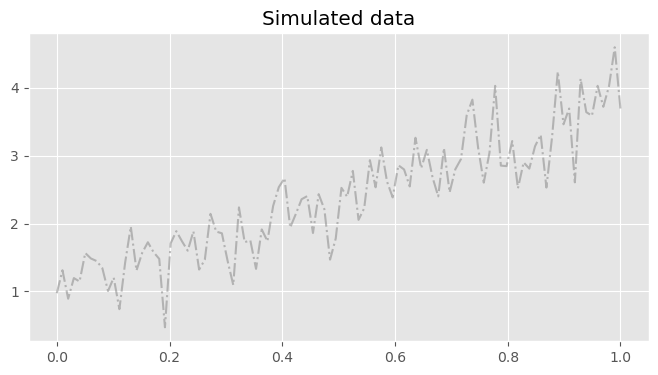

In [4]:
plt.figure(figsize=(8, 4))
plt.plot(time_stamp, y, alpha=0.5, linestyle='dashdot', color='grey')
plt.title('Simulated data');

#### LG - SMM details

This model is a simple linear growth time series model. That is, the latent state does not change over time. Therefore, the transition matrix is:

$F_t = I$ where $I=$ the identity matrix with no transition noise

The observation matrix "pushes forward" from latent to measurement space. 

In [5]:
# X_t (2 hidden states)
init_dist = dist.Normal(0., 5.).expand([2]).to_event(1)

# F_t
trans_matrix = torch.eye(2)

# eta_t ~ Normal(), Q_t)
trans_dist = dist.Normal(0., 0.05).expand([2]).to_event(1)

# H_t
# hidden_dim x obs_dim
obs_matrix = torch.tensor([[1.], [1.]])
obs_dist = dist.Normal(0., 0.4).expand([1]).to_event(1)

In [6]:
gaussian_hmm = dist.GaussianHMM(
    initial_dist=init_dist,
    transition_matrix=trans_matrix,
    transition_dist=trans_dist,
    observation_dist=obs_dist,
    observation_matrix=obs_matrix,
    duration=time_stamp.size(-2)
    )

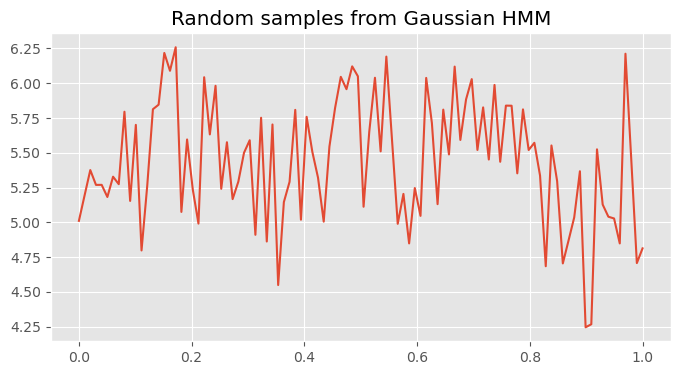

In [7]:
lgsmm_sample = gaussian_hmm.sample()

plt.figure(figsize=(8, 4))
plt.plot(time_stamp, lgsmm_sample);
plt.title('Random samples from Gaussian HMM');

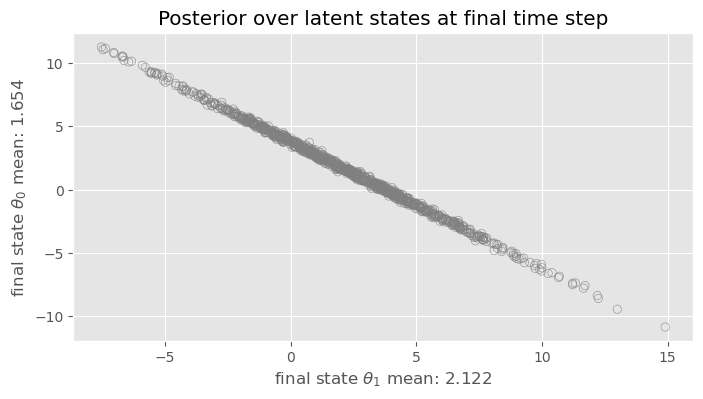

In [8]:
# Compute posterior distribution over latent states 
# at the final time given a sequence of observations.
lgsmm_filter = gaussian_hmm.filter(value=y).sample([1000])

theta_1 = lgsmm_filter[:, 0].mean()
theta_0 = lgsmm_filter[:, 1].mean()

plt.figure(figsize=(8, 4))
plt.scatter(
    lgsmm_filter[:, 0], lgsmm_filter[:, 1],
    alpha=0.75, facecolors='none', edgecolors='grey'
    );
plt.xlabel(f'final state $\\theta_1$ mean: {lgsmm_filter[:, 0].mean():.3f}');
plt.ylabel(f'final state $\\theta_0$ mean: {lgsmm_filter[:, 1].mean():.3f}');
plt.title('Posterior over latent states at final time step');

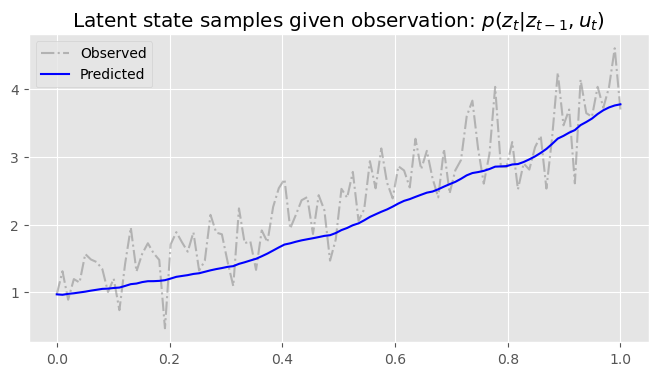

In [12]:
latent_giv_obs = gaussian_hmm.rsample_posterior(y, (100,))

theta_1 = latent_giv_obs.mean(axis=0)[:, 0]
theta_0 = latent_giv_obs.mean(axis=0)[:, 1]

output = [b0 + b1 * t for b0, b1, t in zip(theta_0, theta_1, time_stamp)]

plt.figure(figsize=(8, 4))
plt.plot(time_stamp, y, alpha=0.5, linestyle='dashdot', color='grey')
plt.plot(time_stamp, output, color='blue');
plt.legend(['Observed', 'Predicted'])
plt.title('Latent state samples given observation: $p(z_t|z_{t-1}, u_t)$');

### ARIMA, Expressed as a State Space Model

In [32]:
# ARMA params.
num_timesteps = 500
t = torch.arange(0, num_timesteps).unsqueeze(-1)
phi1 = -0.1
phi2 = 0.5
theta1 = -0.25
sigma = 1.25

In [14]:
# X_0
init_dist = dist.Normal(0., sigma).expand([2]).to_event(1)

# F_t -> AR component
trans_matrix = torch.tensor([[phi1, 1], [phi2, 0]])

# eta_t
R_t = torch.tensor([[sigma], [sigma*theta1]])
#trans_dist = dist.Independent(dist.MultivariateNormal(loc=torch.tensor([[0.]]), scale_tril=R_t), 1)
trans_dist = dist.Normal(0., sigma).expand([2]).to_event(1)

# H_t
#obs_matrix = torch.tensor([[1.], [0.]])
obs_matrix = torch.tensor([[1.], [1.]]) # hidden dims. x obs. dims.
obs_dist = dist.Normal(loc=0., scale=1.).expand([1]).to_event(1)

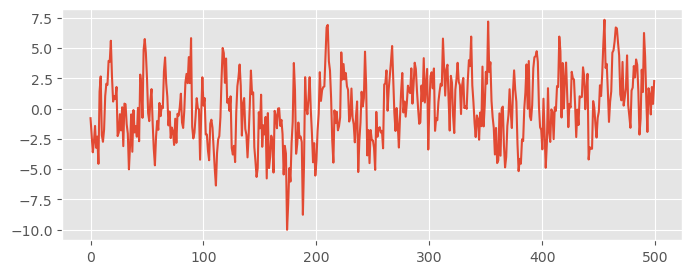

In [33]:
lhmm_sample = dist.GaussianHMM(
    initial_dist=init_dist,
    transition_matrix=trans_matrix,
    transition_dist=trans_dist,
    observation_dist=obs_dist,
    observation_matrix=obs_matrix,
    duration=num_timesteps
    ).sample()

plt.figure(figsize=(8, 3))
plt.plot(t, lhmm_sample);

In [19]:
class ARMA_LGSMM(ForecastingModel):
    def model(self, zero_data, covariates):
        
        time_dim = zero_data.size(-2)
        feature_dim = covariates.size(-2)

        sigma = pyro.sample('sigma', dist.HalfNormal(5.))
        phi = pyro.sample('phi', dist.Normal(0., 0.5).expand([2]))
        theta = pyro.sample('theta', dist.Normal(0., 0.5))

        init_dist = pyro.sample('init_state', dist.Normal(0., sigma).expand([2]).to_event(1))
        
        trans_matrix = torch.tensor([[phi[0], 1], [phi[1], 0]])
        trans_dist =   pyro.sample('trans_dist', dist.Normal(0., sigma).expand([2]).to_event(1))
        
        obs_matrix = torch.tensor([[1.], [1.]])
        obs_dist = pyro.sample('obs_matrix', dist.Normal(loc=0., scale=1.).expand([1]).to_event(1))

        gmm = dist.GaussianHMM(
                initial_dist=init_dist,
                transition_matrix=trans_matrix,
                transition_dist=trans_dist,
                observation_dist=obs_dist,
                observation_matrix=obs_matrix,
                duration=time_dim
                )

        #prediction = (weight * covariates).sum(-1, keepdim=True)

        self.predict(gmm, pred)

In [ ]:
pyro.set_rng_seed(1)
pyro.clear_param_store()

covariates = torch.empty(len(t), 0)
#forecaster = Forecaster(LGSMM(), y, covariates, learning_rate=0.1, num_steps=600)

lgsmm_hmc = HMCForecaster(
    model=ARMA_LGSMM(), 
    data=lhmm_sample, 
    covariates=t,
    num_warmup=100,
    num_samples=500
    )

# for name, value in forecaster.guide.median().items():
#     if value.numel() == 1:
#         print("{} = {:0.4g}".format(name, value.item()))

In [37]:
from pyro.contrib.timeseries.lgssm import GenericLGSSM

In [ ]:
GenericLGSSM(
    
)

In [63]:
def arma_lgsmm(covariate, obs=None):

    time_duration = covariate.size(-2)

    sigma = pyro.sample('sigma', dist.HalfNormal(5.))
    phi = pyro.sample('phi', dist.Normal(0., 0.5).expand([2]))
    theta = pyro.sample('theta', dist.Normal(0., 0.5))

    init_dist = pyro.sample('init_state', dist.Normal(0., sigma).expand([2]).to_event(1))
    
    trans_matrix = torch.tensor([[phi[0], 1], [phi[1], 0]])
    trans_dist =   pyro.sample('trans_dist', dist.Normal(0., sigma).expand([2]).to_event(1))
    
    obs_matrix = torch.tensor([[1.], [1.]])
    obs_dist = pyro.sample('obs_matrix', dist.Normal(loc=0., scale=1.).expand([1]).to_event(1))

    out = pyro.sample(
        'out',
        dist.GaussianHMM(
            initial_dist=init_dist,
            transition_matrix=trans_matrix,
            transition_dist=trans_dist,
            observation_dist=obs_dist,
            observation_matrix=obs_matrix,
            duration=time_duration
            ), obs=obs
        )

    return out


In [ ]:
pyro.render_model(model=arma_lgsmm, model_args=(t, lgsmm_sample), render_distributions=True)

In [17]:
time = torch.arange(0, 500)

In [ ]:
MCMC(NUTS(arma_lgsmm), 500, 300).run(time)

In [49]:
torch.manual_seed(20200101)
# number of predictors, total observations
p = 5
n = 365 * 3

# start, train end, test end
T0 = 0
T1 = n - 28
T2 = n

# initializing coefficients at zeros, simulate all coefficient values
beta0 = torch.empty(n, 1).normal_(0, 0.1).cumsum(0)
betas_p = torch.empty(n, p).normal_(0, 0.02).cumsum(0)
betas = torch.cat([beta0, betas_p], dim=-1)

# simulate regressors
covariates = torch.cat(
    [torch.ones(n, 1), torch.randn(n, p) * 0.1],
    dim=-1
)

# observation with noise
y = ((covariates * betas).sum(-1) + 0.1 * torch.randn(n)).unsqueeze(-1)

In [57]:
covariates

tensor([[ 1.0000,  0.0930,  0.0765, -0.1213, -0.1390, -0.0690],
        [ 1.0000, -0.0693,  0.2619, -0.0411,  0.0899,  0.0387],
        [ 1.0000, -0.1019,  0.0536,  0.0404, -0.0072,  0.0185],
        ...,
        [ 1.0000,  0.0795,  0.0164,  0.0302, -0.0588, -0.1923],
        [ 1.0000, -0.0158,  0.0446, -0.0808,  0.1034, -0.0680],
        [ 1.0000, -0.1218,  0.2101, -0.1866,  0.0522, -0.1523]])

In [ ]:
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))
for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y, 'k-', label='truth', alpha=.8)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:, idx -  1], 'k-', label='truth', alpha=.8)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

In [52]:
from pyro import poutine
from pyro.infer.reparam import LocScaleReparam

class DLM(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-10, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))

        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace
        pyro.deterministic("weight", weight)

        prediction = (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)

        self.predict(noise_dist, prediction)

In [55]:
y[:T1].size(), covariates[:T1].size()

(torch.Size([1067, 1]), torch.Size([1067, 6]))

In [53]:
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = DLM()
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=1000,
)

INFO 	 step    0 loss = 7.11372e+10
INFO 	 step  100 loss = 112.264
INFO 	 step  200 loss = 2.11874
INFO 	 step  300 loss = 1.33891
INFO 	 step  400 loss = 1.05069
INFO 	 step  500 loss = 1.06393
INFO 	 step  600 loss = 1.38096
INFO 	 step  700 loss = 1.23818
INFO 	 step  800 loss = 1.04506
INFO 	 step  900 loss = 0.829916
